
# ARSENL Backscatter Experiments

Grant Kirchhoff
05-31-2022
University of Colorado Boulder

Fit the photon arrival time tags to Gaussian profiles from ARSENL INPHAMIS lidar. 

IMPORTANT: Set data path settings in
'load_ARSENL_data.py' first.

In [41]:
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt

from load_ARSENL_data import load_INPHAMIS_data, data_dir, fname, picklename

In [42]:
# Constants
c = 299792458  # [m/s] Speed of light

# Parameters
create_csv = 0  # Set true to generate a .csv from .ARSENL data
load_data = False  # Set true to load data into a DataFrame and serialize into a pickle object
irregular_data = True  # Set true if data has gaps (i.e., dtime is 0 for many clock cycles)
exclude = [20000, 40000]  # Set boundaries for binning

In [43]:
# Load INPHAMIS .ARSENL data if not yet serialized
if load_data:
    load_INPHAMIS_data(data_dir, fname, picklename, create_csv)

# Unpickle the data to DataFrame object
infile = open('{}/{}'.format(data_dir, picklename), 'rb')
df = pickle.load(infile)
infile.close()

In [44]:
# Extract detections events

df1 = df.loc[df['dtime'] != 0]
detect = df1.loc[(df1['overflow'] == 0) & (df1['channel'] == 0)]  # Return data for detection event ("overflow","channel" = 0,0)

sync_detect_idx = np.array(detect.index) - 1  # Extract index immediately prior to detection event to match with laser pulse
sync_detect = df.loc[sync_detect_idx]  # Laser pulse event prior to detection event
# If data has gaps: Ignore data where a detection event immediately follows a data gap
if irregular_data:
    sync_detect = sync_detect.loc[sync_detect['dtime'] != 0]
    detect = df1.loc[np.array(sync_detect.index + 1)]

In [45]:
# Convert sync/detection events to flight times

detect_time = detect['dtime'].to_numpy()
sync_detect_time = sync_detect['dtime'].to_numpy()

flight_time = (detect_time - sync_detect_time) * 25  # [ps] Time is in segments of 25 ps
flight_time = flight_time[np.where((flight_time >= exclude[0]) & (flight_time < exclude[1]))]  # Exclude t.o.f. where bins ~= 0
distance = flight_time / 1e12 * c / 2

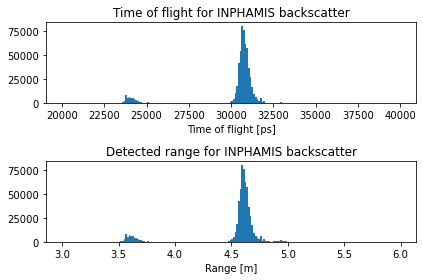

In [46]:
# Time-of-flight histogram

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
n1, bins1, patches1 = ax1.hist(flight_time, bins=200)
n2, bins2, patches2 = ax2.hist(distance, bins=200)
ax1.set_xlabel('Time of flight [ps]')
ax1.set_title('Time of flight for INPHAMIS backscatter')
ax2.set_xlabel('Range [m]')
ax2.set_title('Detected range for INPHAMIS backscatter')
plt.tight_layout()
plt.show()

#### Starting out with testing scipy.optimize.curve_fit

In [49]:
# Gaussian

def gaussian(t, A, mu, sig, b):
    return A * np.exp(-(t-mu)**2 / (2*sig**2)) + b

In [106]:
# Fit algorithm

from numpy.random import default_rng
from scipy.optimize import curve_fit

t = np.linspace(-500, 500, 1001)

x = gaussian(t, 2, 100, 100, 4)
rng = np.random.default_rng()
n = 0.02 * rng.normal(size=t.size)
y = x + n

In [107]:
popt, pcov = curve_fit(gaussian, t, y)

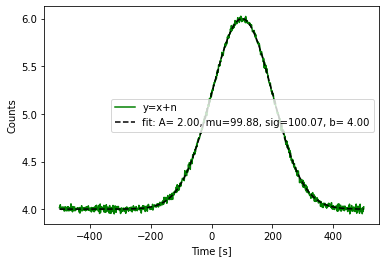

In [108]:
# plt.plot(t, x, 'b-', label='x')
plt.plot(t, y, 'g-', label='y=x+n')
plt.plot(t, gaussian(t, *popt), 'k--', \
         label='fit: A=%5.2f, mu=%5.2f, sig=%5.2f, b=%5.2f' % tuple(popt))
plt.xlabel('Time [s]')
plt.ylabel('Counts')
plt.legend()

#### Now transitioning to applying the curve_fit routine to my data

In [109]:
distance

array([4.66177272, 4.66926753, 4.66926753, ..., 4.76295268, 4.64303569,
       4.56059277])

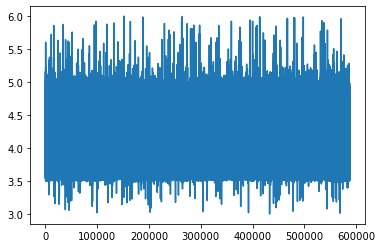

In [110]:
plt.plot(distance)

In [113]:
distance

array([4.66177272, 4.66926753, 4.66926753, ..., 4.76295268, 4.64303569,
       4.56059277])